In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
from pathlib import Path
import os, sys, datetime, time, random, fnmatch, math
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import skimage.metrics

import torch
from torchvision import transforms as tvtransforms
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.utils as vutils
import torch.utils.tensorboard as tensorboard
import torch.nn as nn

import datasets, transforms, GusarevModel, pytorch_msssim

flag_debug = False

# Input Directories
#data_BSE = "D:/data/JSRT/BSE_JSRT"
#data_normal = "D:/data/JSRT/JSRT"
data_BSE = "G:/DanielLam/JSRT/augmented/augmented/target"
data_normal = "G:/DanielLam/JSRT/augmented/augmented/source"

# Save directories:
output_save_directory = Path("./runs/6LayerCNN/v3")
output_save_directory.mkdir(parents=True, exist_ok=True)
PATH_SAVE_NETWORK_INTERMEDIATE = os.path.join(output_save_directory, 'network_intermediate.pt' )
PATH_SAVE_NETWORK = os.path.join(output_save_directory, 'network_final.pt')

# Image Size:
image_spatial_size = (440,440)
_batch_size = 5
test_length = 10

# Optimisation
lr_ini = 0.0002 
beta1 = 0.5
beta2 = 0.999

# Training
num_reals_per_epoch_paper = 4000 # in Gusarev et al. 2017
total_num_epochs_paper = 30 # 150
num_epochs_decay_lr_paper = 100
lr_decay_ratio = 0.25

# Weight Initialisation
def weights_init(m):
    classname = m.__class__.__name__
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        #nn.init.normal_(m.weight.data, 0., 0.02)
        nn.init.kaiming_normal_(m.weight.data,0)
        try:
            nn.init.constant_(m.bias.data, 0.)
        except:
            pass
    if isinstance(m, nn.BatchNorm2d) or isinstance(m, nn.InstanceNorm2d):
        if m.affine:
            nn.init.normal_(m.weight.data, 1.0, 0.02)
            nn.init.constant_(m.bias.data, 0.)

## Code for putting things on the GPU
ngpu = 1 #torch.cuda.device_count()
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
device = torch.device("cuda" if (torch.cuda.is_available() and ngpu > 0) else "cpu")
print(device)
print(torch.cuda.get_device_name(torch.cuda.current_device()))

cuda
GeForce RTX 2080 Ti


(4070, 10)


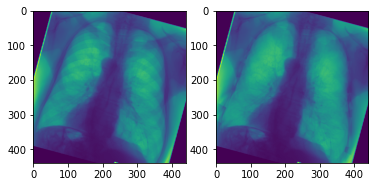

In [2]:
# Current date:
current_date=datetime.datetime.today().strftime('%Y-%m-%d')

# Data Loader
discriminator_keys_images = ["source", "boneless"]
target_key = "boneless"
ds = datasets.JSRT_CXR(data_normal, data_BSE,
                         transform=tvtransforms.Compose([
                             #transforms.CLAHE(discriminator_keys_images), -- takes ages
                             #transforms.ZScoreNormalisation(discriminator_keys_images),
                             transforms.RescalingNormalisation(discriminator_keys_images,(0,1)),
                             #transforms.RandomHorizontalFlip(discriminator_keys_images, probability=0.5),
                             #transforms.RandomVerticalFlip(discriminator_keys_images, probability=0.5),
                             #transforms.IntensityJitter(discriminator_keys_images,source_image_key="source", rescale_factor_limits=(0.75,1.0), window_motion_limits=(-1,1)),
                             transforms.RandomIntensityComplement(discriminator_keys_images, probability=0.5),
                             #transforms.RandomRotation(discriminator_keys_images),
                             transforms.Rescale(image_spatial_size, discriminator_keys_images, None),
                             transforms.ToTensor(discriminator_keys_images),
                             ])
                      )

# SPLIT DATA INTO TRAINING/VALIDATION SET
lengths=(len(ds)-test_length, test_length)
print(lengths)
ds_training, ds_val = torch.utils.data.random_split(ds, lengths)

dl_training = DataLoader(ds_training, batch_size=_batch_size,
                         shuffle=True, num_workers=0)

dl_validation = DataLoader(ds_val, batch_size=1,
                         shuffle=False, num_workers=0)
fixed_val_sample = next(iter(dl_validation))

fig, ax = plt.subplots(1,2)
ax[0].imshow(fixed_val_sample["source"][0,0,:])
ax[1].imshow(fixed_val_sample["boneless"][0,0,:])
plt.show()

In [3]:
## Implementation of network and losses
input_array_size = (_batch_size, 1, image_spatial_size[0], image_spatial_size[1])
net = GusarevModel.MultilayerCNN(input_array_size)
# Initialise weights
net.apply(weights_init)

# Multi-GPU
if (device.type == 'cuda') and (ngpu > 1):
    print("Neural Net on GPU")
    net = nn.DataParallel(net, list(range(ngpu)))
net = net.to(device)

# Optimiser
optimizer = torch.optim.Adam(net.parameters(), lr=lr_ini, betas=(beta1, beta2))

# Learning Rate Scheduler
epoch_factor = round(num_reals_per_epoch_paper/len(ds_training)) # need to have this factor as many epochs as that described in the paper
print("Epoch Factor: "+str(epoch_factor))
total_num_epochs = total_num_epochs_paper*epoch_factor
num_epochs_decay_lr = num_epochs_decay_lr_paper*epoch_factor

lambda_rule = lambda epoch: 1*((1-lr_decay_ratio)**(epoch//num_epochs_decay_lr))

print(optimizer.state_dict)
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda_rule, verbose=True)

# Gusarev Loss
def criterion_MSELoss(testImage, referenceImage):
    mse = nn.MSELoss()
    mse_loss = mse(testImage, referenceImage)
    return mse_loss, mse_loss, torch.zeros(1)
def criterion_Gusarev(testImage, referenceImage, alpha=0.84):
    """
    Gusarev et al. 2017. Deep learning models for bone suppression in chest radiographs.  IEEE Conference on Computational Intelligence in Bioinformatics and Computational Biology.
    """
    mse = nn.MSELoss() # L2 used for easier optimisation c.f. L1
    mse_loss = mse(testImage, referenceImage)
    msssim = pytorch_msssim.MSSSIM(window_size=11, size_average=True, channel=1, normalize='relu')
    msssim_loss = 1 - msssim(testImage, referenceImage)
    total_loss = (1-alpha)*mse_loss + alpha*msssim_loss
    return total_loss, mse_loss, msssim_loss

Using 6-Layer MultiCNN Model.
Epoch Factor: 1
<bound method Optimizer.state_dict of Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.5, 0.999)
    eps: 1e-08
    lr: 0.0002
    weight_decay: 0
)>
Adjusting learning rate of group 0 to 2.0000e-04.


In [ ]:
# Training
img_list = []
loss_list = []
reals_shown = []


# For each epoch
print(target_key)
flag_break = False # when debugging, this will automatically go to True
iters = 0
reals_shown_now = 0
for param in net.parameters():
    param.requires_grad = True
for epoch in range(total_num_epochs ):
    print(scheduler.get_last_lr())
    for i, data in enumerate(dl_training):
        # Training
        net.zero_grad()
        noisy_data = data["source"].to(device)
        cleaned_data = net(noisy_data)
        loss, mseloss, msssim_loss = criterion_Gusarev(cleaned_data, data[target_key].to(device))
        loss.backward() # calculate gradients
        optimizer.step() # optimiser step along gradients
        
        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tTotal Loss: %.4f\tMSELoss: %.4f\tMSSSIM Loss: %.4f'
                  % (epoch, total_num_epochs, i, len(dl_training),
                     loss.item(), mseloss.item(), msssim_loss.item()))
        # Record generator output
        if reals_shown_now%(100*_batch_size)==0:
            with torch.no_grad():
                val_cleaned = net(fixed_val_sample["source"].to(device)).detach().cpu()
            print("Printing to img_list")
            img_list.append(vutils.make_grid(val_cleaned, padding=2, normalize=True))
        iters +=1
        reals_shown_now += _batch_size
        reals_shown.append(reals_shown_now)
        loss_list.append(loss.item())
        
        if flag_debug and iters>=10:
            flag_break = True
            break
    # LR Scheduler
    scheduler.step()
    
    # Save the network in indications
    if epoch % 10 == 0:
        if not flag_debug:
            torch.save(net.state_dict(), PATH_SAVE_NETWORK_INTERMEDIATE)
            print("Saved Intermediate: "+ str(PATH_SAVE_NETWORK_INTERMEDIATE))
    if flag_break:
        break

if not flag_debug:
    torch.save(net.state_dict(), PATH_SAVE_NETWORK)

boneless
[0.0002]
[0/30][0/814]	Total Loss: 0.5055	MSELoss: 0.1646	MSSSIM Loss: 0.5704
Printing to img_list
[0/30][50/814]	Total Loss: 0.2003	MSELoss: 0.0277	MSSSIM Loss: 0.2332
[0/30][100/814]	Total Loss: 0.2002	MSELoss: 0.0214	MSSSIM Loss: 0.2342
Printing to img_list
[0/30][150/814]	Total Loss: 0.2027	MSELoss: 0.0525	MSSSIM Loss: 0.2313
[0/30][200/814]	Total Loss: 0.1854	MSELoss: 0.0232	MSSSIM Loss: 0.2163
Printing to img_list
[0/30][250/814]	Total Loss: 0.1446	MSELoss: 0.0120	MSSSIM Loss: 0.1699
[0/30][300/814]	Total Loss: 0.1786	MSELoss: 0.0127	MSSSIM Loss: 0.2102
Printing to img_list
[0/30][350/814]	Total Loss: 0.1515	MSELoss: 0.0192	MSSSIM Loss: 0.1767
[0/30][400/814]	Total Loss: 0.1584	MSELoss: 0.0251	MSSSIM Loss: 0.1838
Printing to img_list
[0/30][450/814]	Total Loss: 0.1371	MSELoss: 0.0111	MSSSIM Loss: 0.1611
[0/30][500/814]	Total Loss: 0.1481	MSELoss: 0.0204	MSSSIM Loss: 0.1725
Printing to img_list
[0/30][550/814]	Total Loss: 0.1473	MSELoss: 0.0141	MSSSIM Loss: 0.1726
[0/30][

In [ ]:
print("Training complete")

In [ ]:
%matplotlib inline

current_date=datetime.datetime.today().strftime('%Y-%m-%d')

# Loss for training
plt.figure(figsize=(10,5))
plt.title("Loss During Training")
plt.plot(reals_shown, loss_list)
plt.xlabel("reals_shown")
plt.ylabel("Loss")
if not flag_debug:
    plt.savefig(os.path.join(output_save_directory, current_date + "training_loss"+".png"))

# Final Model:
with torch.no_grad():
    input_image = fixed_val_sample['source']
    input_images = vutils.make_grid(input_image[0:1,:,:,:], padding=2, normalize=True)
    target_images = vutils.make_grid(fixed_val_sample['boneless'][0:1,:,:,:], padding=2, normalize=True)
    net = net.cpu()
    output_image = net(input_image[0:1,:,:,:]).detach().cpu()
    output_images = vutils.make_grid(output_image, padding=2, normalize=True)
print(str(torch.max(output_images)) + "," + str(torch.min(output_images)))
plt.figure(1)
fig, ax = plt.subplots(1,3, figsize=(15,15))
ax[0].imshow(np.transpose(input_images, (1,2,0)), vmin=0, vmax=1)
ax[0].set_title("Source")
ax[0].axis("off")
ax[1].imshow(np.transpose(output_images, (1,2,0)), vmin=0, vmax=1)
ax[1].set_title("Suppressed")
ax[1].axis("off")
ax[2].imshow(np.transpose(target_images, (1,2,0)), vmin=0, vmax=1)
ax[2].set_title("Target")
ax[2].axis("off")
plt.show
if not flag_debug:
    plt.savefig(os.path.join(output_save_directory, current_date + "_comparisonImages"+".png"))

    
# ANIMATED VALIDATION IMAGE
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=200, repeat_delay=1000, blit=True)
if not flag_debug:
    ani.save(os.path.join(output_save_directory, current_date+"_animation.mp4"), dpi=300)

In [ ]:
num_list = np.arange(0,100)
a = np.arange(0,100,10)
print(num_list)
print(num_list[a])